In [1]:
# %%
# Load packages
import os
import sklearn
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torcheval.metrics.functional import r2_score
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torchsummary import summary

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [2]:
model = torch.hub.load('pytorch/vision:v0.20.0', 'resnet50')
model.fc = nn.Linear(in_features=2048,out_features=2,bias=True)
model.conv1 = nn.Conv2d(in_channels=6,out_channels=64,kernel_size=(7,7),stride=(2,2),padding=(3,3),bias=False)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)

model.to(device)
summary(model, input_size=(6, 224, 224), device=device)


Using cache found in C:\Users\jonat/.cache\torch\hub\pytorch_vision_v0.20.0


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]          18,816
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [3]:
# Change CSV file
def change_csv_file(csv_file):
    # Read the CSV file
    df = pd.read_csv(csv_file)
    # Create 2 new columns
    df["camera_01"] = df.index.to_series().apply(lambda x: f"image_01_{x + 1}.jpg")
    df["camera_02"] = df.index.to_series().apply(lambda x: f"image_02_{x + 1}.jpg")
    # Save the new CSV file
    df.to_csv('data/rotations_w_images.csv', index=False)

change_csv_file("data/rotations.csv")

In [4]:
# Dataset
class WindTurbineDataset(Dataset):
    """
        Args:
            root_dir (string): Directory with csv and image folder.
            csv_file (string): Path to the csv file with filenames and angles
            image_folder (string): Directory with images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
    def __init__(self, csv_file, image_folder, root_dir, images_num=1, transform_size=None):
        self.root_dir = root_dir
        csv_path =  os.path.join(self.root_dir, csv_file)
        self.rotations_df = pd.read_csv(csv_path)
        self.transform_size = transform_size
        self.image_folder = []
        for i in range(images_num):
            self.image_folder.append(image_folder+f"_0{i+1}/")

    def __len__(self):
        return len(self.rotations_df)
    
    def _transform(self, transform_size, image):
        transform = transforms.Compose([
        transforms.CenterCrop(300),
        transforms.Resize(224),
        transforms.ToTensor(),
        ])
        return transform(image)


    def __getitem__(self, idx):
        # Get the image file path
        images = []
        for i in range(len(self.image_folder)):
            img_name = (os.path.join(self.root_dir, self.image_folder[i], self.rotations_df.iloc[idx, i+2])) #'filename' is the third column
            images.append(Image.open(img_name))
        base_angles = self.rotations_df.iloc[idx, 0] 
        blade_angles = self.rotations_df.iloc[idx, 1]
        angles = torch.tensor([base_angles, blade_angles], dtype=torch.float32)

        images = [self._transform(self.transform_size, image) for image in images]
        images = torch.concatenate(images, dim=0)  

        return images, angles

In [5]:
# Dataloader
class WindTurbineDataloader(Dataset):
    @staticmethod
    def train_test_split(dataset, test_size=0.2):
        # Split the dataset into training and testing sets
        train_size = int((1 - test_size) * len(dataset))
        test_size = len(dataset) - train_size
        train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
        # Seperate the labels from the features
        return train_dataset, test_dataset
    @staticmethod
    def dataloader(dataset, batch_size=64, shuffle=True):
        return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [6]:
class AngularLoss(nn.Module):
    def __init__(self):
        super(AngularLoss, self).__init__()
    
    def forward(self, pred_init, target_init, is_degrees=False):
        pred = pred_init
        target = target_init
        """
        Computes the loss for angular data.
        pred: Tensor of shape (batch_size, 2), predicted angles (in degrees or radians).
        target: Tensor of shape (batch_size, 2), target angles (in degrees or radians).
        is_degrees: Boolean indicating if the angles are in degrees (default: False).
        """
        if is_degrees:
            pred = pred
            target = target
        
        # Compute smallest angular difference
        angular_diff = torch.atan2(torch.sin(pred - target), torch.cos(pred - target))
        
        # Scale the loss by a factor of 10
        angular_diff = angular_diff * 10
        
        # Loss is the mean squared angular difference
        loss = torch.mean((angular_diff)** 2)
        return loss

In [ ]:
#%%
batch_size = 64
# Load data
wind_dataset = WindTurbineDataset(csv_file='rotations_w_images.csv', image_folder='camera', root_dir='data/', images_num=1)
train_dataset, test_dataset = WindTurbineDataloader.train_test_split(wind_dataset, test_size=0.2)
trainloader = WindTurbineDataloader.dataloader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = WindTurbineDataloader.dataloader(test_dataset, batch_size=batch_size, shuffle=True)
# Load model
# Loss function
criterion = AngularLoss()
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
schedular = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [8]:
#%%
# Training
class Trainer:
    train_loss = []
    test_loss = []

    def __init__(self, model, trainloader, testloader, criterion, optimizer, device, epochs=10):
        self.model = model
        self.trainloader = trainloader
        self.testloader = testloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.epochs = epochs
    
    def _train(self, dataloader, model, criterion, optimizer, device):
        model.train()
        running_loss = 0.0

        for _, data in enumerate(dataloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Compute the prediction error
            pred = model(inputs)
            loss = criterion(pred, labels, is_degrees=True)
            running_loss += loss.item()

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        schedular.step()
        avg_loss = running_loss / len(dataloader)
        return avg_loss
    
    def _test(self, dataloader, model, criterion, device):
        model.eval()
        running_loss = 0.0

        with torch.no_grad():
            for _, data in enumerate(dataloader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                # Compute the prediction error
                pred = model(inputs)
                loss = criterion(pred, labels, is_degrees=True)
                running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        return avg_loss
    
    def train_model(self):
        for epoch in range(self.epochs):
            train_loss = self._train(self.trainloader, self.model, self.criterion, self.optimizer, self.device)
            test_loss = self._test(self.testloader, self.model, self.criterion, self.device)
            self.train_loss.append(train_loss)
            self.test_loss.append(test_loss)
            print(f"Epoch {epoch + 1}/{self.epochs}, Train Loss: {train_loss}, Test Loss: {test_loss}")


In [ ]:
#%%
trainer = Trainer(model, trainloader, testloader, criterion, optimizer, device, epochs=150)
trainer.train_model()
# Plot the training and testing loss
plt.plot(trainer.train_loss, label="Train Loss")
plt.plot(trainer.test_loss, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Epoch 1/15, Train Loss: 328.00954768088013, Test Loss: 327.7074574437635
Epoch 2/15, Train Loss: 328.9039363354708, Test Loss: 334.7249808475889
Epoch 3/15, Train Loss: 329.31541537394565, Test Loss: 316.4696528993804
Epoch 4/15, Train Loss: 332.8344337665929, Test Loss: 337.1684938628098
Epoch 5/15, Train Loss: 328.0733502143252, Test Loss: 338.6412795494343
Epoch 6/15, Train Loss: 327.3712101489042, Test Loss: 326.27766050141435
Epoch 7/15, Train Loss: 329.08782148783183, Test Loss: 330.51411069672685
Epoch 8/15, Train Loss: 328.93137379874173, Test Loss: 316.15670197585536


KeyboardInterrupt: 

In [10]:
model.eval()
running_loss = 0.0

with torch.no_grad():
    for _, data in enumerate(testloader):
        inputs, labels = data
        inputs_n, labels_n = inputs.to(device), labels.to(device)

        # Compute the prediction error
        pred = model(inputs_n)
        loss = criterion(pred,labels_n,is_degrees=True)
        running_loss += loss.item()
avg_loss = running_loss / len(testloader)

[  -6.665883    -6.594451    -6.5696793   -6.6529307 -749.6507
   -6.5962944   -6.6765018 -804.93896  ]


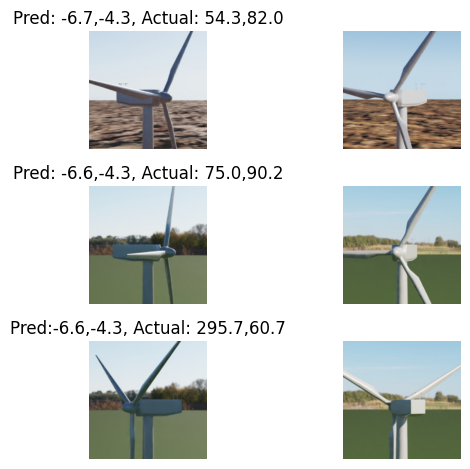

In [11]:
im1 = inputs[:,0:3,:,:]
im1 = torch.permute(im1,(0,2,3,1)).numpy()
im2 = inputs[:,3:6,:,:]
im2 = torch.permute(im2,(0,2,3,1)).numpy()
preds = torch.Tensor.cpu(pred).numpy()
rot_base = labels[:,0]
rot_wings = labels[:,1]
pred_base = preds[:,0]
pred_wings = preds[:,1]
print(pred_base)

ax = plt.subplot(3,2,1)
ax.imshow(im1[0,:,:,:])
ax.set_axis_off()
ax.set_title(f"Pred: {pred_base[0]:.1f},{pred_wings[0]:.1f}, Actual: {rot_base[0]:.1f},{rot_wings[0]:.1f}")

ax = plt.subplot(3,2,2)
ax.imshow(im2[0,:,:,:])
ax.set_axis_off()

ax = plt.subplot(3,2,3)
ax.imshow(im1[1,:,:,:])
ax.set_axis_off()
ax.set_title(f"Pred: {pred_base[1]:.1f},{pred_wings[1]:.1f}, Actual: {rot_base[1]:.1f},{rot_wings[1]:.1f}")

ax = plt.subplot(3,2,4)
ax.imshow(im2[1,:,:,:])
ax.set_axis_off()

ax = plt.subplot(3,2,5)
ax.imshow(im1[2,:,:,:])
ax.set_axis_off()
ax.set_title(f"Pred:{pred_base[2]:.1f},{pred_wings[2]:.1f}, Actual: {rot_base[2]:.1f},{rot_wings[2]:.1f}")

ax = plt.subplot(3,2,6)
ax.imshow(im2[2,:,:,:])
ax.set_axis_off()

plt.tight_layout()
